# Writers and Directors

What data sets?
- tn movie budgets
- IMDB title crew, IMDB name basics, IMDB title basics

In [100]:
import pandas as pd
import seaborn as sns
import numpy as np
from pandasql import sqldf
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_context('notebook')

IMDB name basics, provides writer and director names

In [3]:
#From Erica's data cleaning
imdb_name_df = pd.read_csv('zippedData/imdb.name.basics.csv.gz', compression='gzip')
imdb_name_df = imdb_name_df.drop(columns=['birth_year', 'death_year']) #Both of these columns are missing ~85%+ values 

imdb_name_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 606648 entries, 0 to 606647
Data columns (total 4 columns):
nconst                606648 non-null object
primary_name          606648 non-null object
primary_profession    555308 non-null object
known_for_titles      576444 non-null object
dtypes: object(4)
memory usage: 18.5+ MB


Import combined/cleaned data set with includes TN budget/gross data, and IMDB movie name, movie ID, directory and writer IDs

In [15]:
df = pd.read_csv('TN_budget_and_IMDB.csv').drop_duplicates('tconst')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3625 entries, 0 to 3839
Data columns (total 8 columns):
movie                3625 non-null object
genres               3625 non-null object
directors            3625 non-null object
writers              3625 non-null object
production_budget    3625 non-null int64
domestic_gross       3625 non-null int64
worldwide_gross      3625 non-null int64
tconst               3625 non-null object
dtypes: int64(3), object(5)
memory usage: 254.9+ KB


In [17]:
df.head(10)

,movie,genres,directors,writers,production_budget,domestic_gross,worldwide_gross,tconst
0,Foodfight!,"Action,Animation,Comedy",nm0440415,"nm0440415,nm0923312,nm0295165,nm0841854,nm0220297",45000000,0,73706,tt0249516
1,Mortal Kombat,"Action,Adventure,Fantasy",nm2585406,nm3859643,20000000,70433227,122133227,tt0293429
2,The Overnight,Genre Data Missing,nm1208371,"nm1170333,nm1208371",200000,1109808,1165996,tt0326592
3,On the Road,"Adventure,Drama,Romance",nm0758574,"nm0449616,nm1433580",25000000,720828,9313302,tt0337692
4,The Secret Life of Walter Mitty,"Adventure,Comedy,Drama",nm0001774,"nm0175726,nm0862122",91000000,58236838,187861183,tt0359950
5,A Walk Among the Tombstones,"Action,Crime,Drama",nm0291082,"nm0088747,nm0291082",28000000,26017685,62108587,tt0365907
6,Jurassic World,"Action,Adventure,Sci-Fi",nm1119880,"nm0415425,nm0798646,nm1119880,nm2081046,nm0000341",215000000,652270625,1648854864,tt0369610
7,The Rum Diary,"Comedy,Drama",nm0732430,"nm0732430,nm0860219",45000000,13109815,21544732,tt0376136
8,The Three Stooges,"Comedy,Family","nm0268380,nm0268370","nm0148808,nm0268370,nm0268380",30000000,44338224,54052249,tt0383010
9,Anderson's Cross,"Comedy,Drama,Romance",nm1516329,nm1516329,300000,0,0,tt0393049


Next steps: change director/writer ids to names, split cs cells to multiple rows, group by director or writer. Remove rows with no gross income data. Consider mean vs median
- need separate databases for director info and writer info

In [46]:
df['num_writers'] = df['writers'].apply(lambda x:len(x.split(',')))
df['num_directors'] = df['directors'].apply(lambda x:len(x.split(',')))

In [49]:
df['num_writers'].value_counts()

1     1791
2      971
3      451
4      210
5       99
6       42
7       18
9       13
8       13
10       9
11       3
25       1
13       1
20       1
14       1
12       1
Name: num_writers, dtype: int64

In [104]:
#df['production_budget'] = df['production_budget'].apply(lambda x:x/1000000)
df['worldwide_gross'] = df['worldwide_gross'].apply(lambda x:x/1000000)

[Text(0, 0.5, 'Number of Writers'),
 Text(0.5, 0, 'Production Budget (in Millions)'),
 Text(0.5, 1.0, 'Number of Writers vs Cost')]

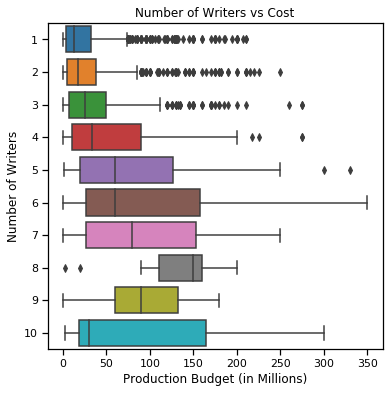

In [113]:
plt.figure(figsize=(6,6))
ax = sns.boxplot(x='production_budget',y='num_writers',data=df.query('num_writers<11 & production_budget<380'),orient = 'h')
ax.set(ylabel='Number of Writers',xlabel='Production Budget (in Millions)',title='Number of Writers vs Cost')

[Text(0, 0.5, 'Number of Writers'),
 Text(0.5, 0, 'Worldwide Gross (in Millions)'),
 Text(0.5, 1.0, 'Number of Writers vs Revenue')]

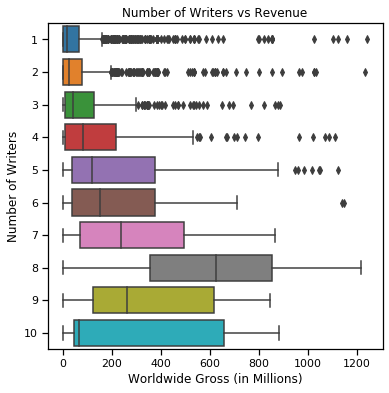

In [112]:
plt.figure(figsize=(6,6))
ax = sns.boxplot(x='worldwide_gross',y='num_writers',data=df.query('num_writers<11 & worldwide_gross<1250'),orient='h')
ax.set(ylabel='Number of Writers',xlabel='Worldwide Gross (in Millions)',title='Number of Writers vs Revenue')

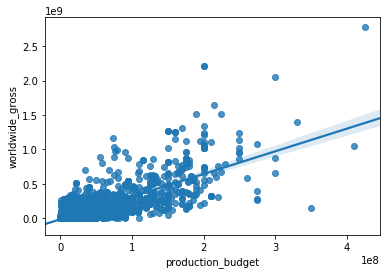

In [66]:
sns.regplot(x='production_budget',y='worldwide_gross',data=df)

In [75]:
df.corr()

,production_budget,domestic_gross,worldwide_gross,num_writers,num_directors
production_budget,1.000000,0.721550,0.771622,0.317620,0.014774
domestic_gross,0.721550,1.000000,0.949492,0.266695,0.036130
worldwide_gross,0.771622,0.949492,1.000000,0.280309,0.043281
num_writers,0.317620,0.266695,0.280309,1.000000,0.240984
num_directors,0.014774,0.036130,0.043281,0.240984,1.000000


Interesting correlation coefficient:
- number writers x production budget: 0.31762
- number writers x domestic gross/worldwide gross: 0.266695/0.280309
- production budget x d gross/ww gross: 0.721550/0.771622

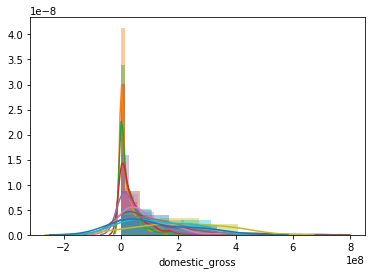

In [91]:
for i in list(range(11)):
    qstr = 'num_writers == '+str(i)
    sns.distplot(df.query(qstr)['domestic_gross'],label=i)

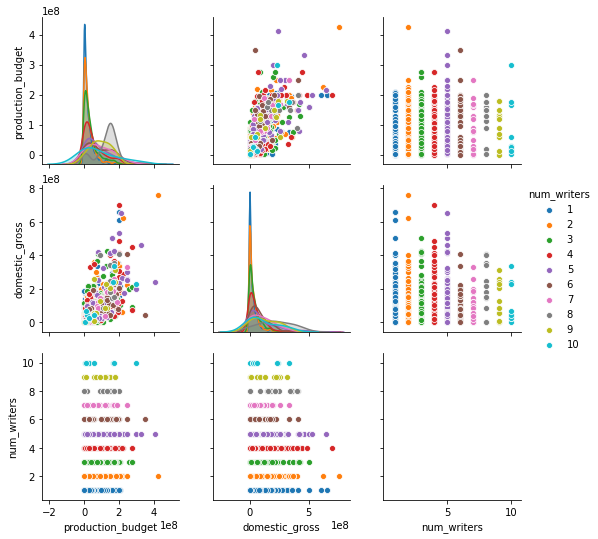

In [80]:
df1 = df[['production_budget','domestic_gross','num_writers']].query('num_writers < 11')
sns.pairplot(df1, hue="num_writers");